In [46]:
from numpy import random as npr
import random
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats as scs

# Simulations en l'absence de télomèrase

## Reconstruction de la distribution stationnaire en présence de télomèrase

In [47]:
# Parameters from the model
s = 3.5
p = 0.026
beta = 0.0236
L_0 = 101
n = 1700 

In [48]:
# gives the probability of action of telomerase as a function of telomere length
def P(L, L_0, beta):
    if L >= L_0:
        return 1./(1 + beta*(L-L_0))
    else:
        return 1

# useful for quick computation
def precompute_arrays(L_0, beta):
    geom = np.array([p*(1-p)**k for k in range(n)])
    probas = np.array([P(k, L_0, beta) for k in range(n)])
    return geom, probas

# one iteration from the distribution computation
def iter_distr(pi, L_0, beta, geom, probas):
    new_pi = np.array([0.]*len(pi))
    for i in range(len(pi)-7):
        pi_i = pi[i+7]*(1-P(i+7, L_0, beta)) + np.sum(geom[:int(i/2.+3.5)]*probas[i+5::-2]*pi[i+5::-2])
        new_pi[i] = pi_i
    for i in range(len(pi)-7, len(pi)):
        new_pi[i] = 0.
    return new_pi

# Many iterations for the distribution computation + graph plot + skewness and mode computation
def evol_distr(n_iter, pi, L_0, beta, verbose=True):
    geom, probas = precompute_arrays(L_0, beta)
    pi2 = np.copy(pi)
    for k in range(n_iter):
        pi2 = iter_distr(pi2, L_0, beta, geom, probas)
        pi2 = pi2 / np.sum(pi2)
    
    r = np.array(range(n))/2
    if verbose:
        plt.figure()
        plt.plot(r, pi2)
        plt.show()
    mode = r[np.argmax(pi2)]
    mean = np.sum(r*pi2)
    std = np.sqrt(np.sum(r**2*pi2)-mean**2)
    skewness = np.sum(((r-mean)/std)**3*pi2)
    
    if verbose:
        print('Mode: ' + str(mode))
        print('Skewness: ' + str(skewness))
        print('Check sum==1: sum=' + str(np.sum(pi2)))
    return pi2, mode, skewness

In [49]:
pi = np.array([0.]*n)
for k in range(L_0, 2*L_0):
    pi[k] = 1./L_0

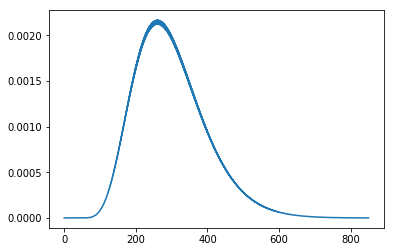

Mode: 260.5
Skewness: 0.729789529549
Check sum==1: sum=1.0
Cumulated sum:


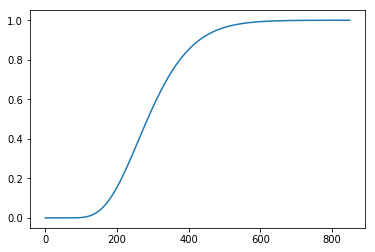

In [50]:
n_iter = 1000
pi_final, m, s = evol_distr(n_iter, pi, L_0, beta)
cdf = np.cumsum(pi_final)
print('Cumulated sum:')
plt.plot(np.arange(0, 850, step=0.5), cdf)
plt.show()

In [51]:
def initialisation_from_distr():
    u = npr.rand()
    return np.where(cdf>u)[0][0] / 2.

In [52]:
def evolution(list_lengths):
    permutation = np.arange(32)
    npr.shuffle(permutation)
    new_lengths = [0]*32
    for k in range(32):
        if permutation[k] >= 17:
            new_lengths[k] = list_lengths[k]
        else:
            new_lengths[k] = list_lengths[k] - npr.randint(5, 11)
    return new_lengths

## Modèle asymétrique

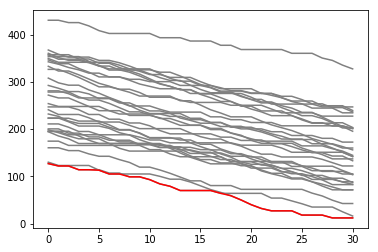

In [53]:
# Exemple
T = 30
list_lengths = [initialisation_from_distr() for k in range(32)]
big_list = [list_lengths]
for t in range(T):
    list_lengths = evolution(list_lengths)
    big_list.append(list_lengths)
for k in range(32):
    plt.plot(range(T+1), [big_list[i][k] for i in range(T+1)], color='grey')
plt.plot(range(T+1), [min(big_list[i]) for i in range(T+1)], color='red')
plt.show()

### Initialisation déterministe ('single founder cell')

In [54]:
n_exp = 10000
L_finales = []
T_final = []
list_lengths_init = [initialisation_from_distr() for k in range(32)]

for exp in range(n_exp):
    T = 0
    list_lengths = list_lengths_init
    longueur = min(list_lengths)
    while longueur > 19:
        T += 1
        list_lengths = evolution(list_lengths)
        longueur = min(list_lengths)
    T_final.append(T)

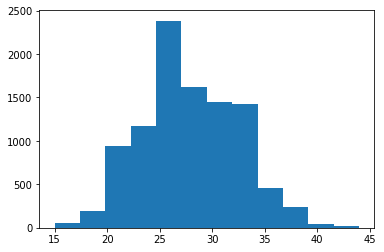

In [55]:
plt.hist(T_final, bins=12)
plt.show()

In [56]:
# Coefficient of variation for single founder cell, asymmetric telomere replication model
print(np.std(T_final)/np.mean(T_final))

0.162200480339


### Initialisation aléatoire ('independent founder cells')

In [57]:
n_exp = 10000
L_finales = []
T_final = []
for exp in range(n_exp):
    T = 0
    list_lengths = [initialisation_from_distr() for k in range(32)]
    longueur = min(list_lengths)
    while longueur > 19:
        T += 1
        list_lengths = evolution(list_lengths)
        longueur = min(list_lengths)
    T_final.append(T)

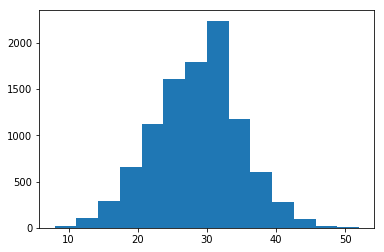

In [58]:
plt.hist(T_final, bins=14)
plt.show()

In [59]:
# Coefficient of variation for single founder cell, asymmetric telomere replication model
print(np.std(T_final)/np.mean(T_final))

0.221721998126


## Modèle symétrique

### Initialisation aléatoire ('independent founder cells')

In [60]:
n_exp = 10000
L_finales = []
T_final = []
for exp in range(n_exp):
    T = 0
    list_lengths = [initialisation_from_distr() for k in range(32)]
    longueur = min(list_lengths)
    T_final.append(int((longueur-19)/3.75)+1)

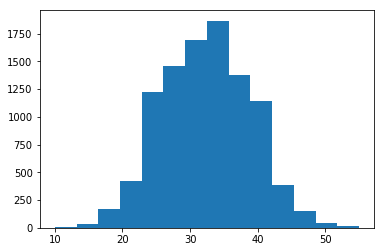

In [61]:
plt.hist(T_final, bins=14)
plt.show()

In [62]:
# Coefficient of variation for single founder cell, asymmetric telomere replication model
print(np.std(T_final)/np.mean(T_final))

0.199351070557


# Verification of useful facts for theoretical analysis

In [63]:
def evolution_simple(longueur):
    x = npr.rand()
    if x > 0.5:
        return longueur - npr.randint(5, 11)
    return longueur

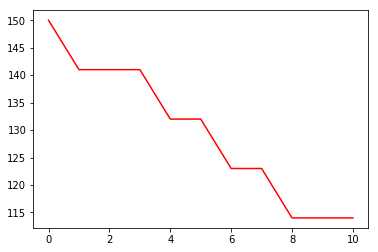

In [64]:
T = 10
longueur = 150
L = [longueur]
for t in range(T):
    longueur = evolution_simple(longueur)
    L.append(longueur)
plt.plot(range(T+1), L, color='red')
plt.show()

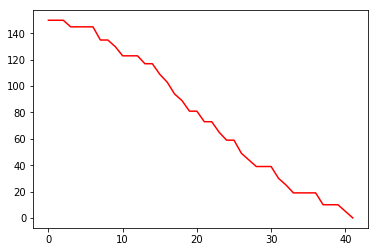

In [65]:
T = 0
longueur = 150
L = [longueur]
while longueur > 0:
    T += 1
    longueur = evolution_simple(longueur)
    L.append(longueur)
plt.plot(range(T+1), L, color='red')
plt.show()

Vérification de l'uniformité de la loi de la marche sachant qu'elle est entre 1 et 10 :

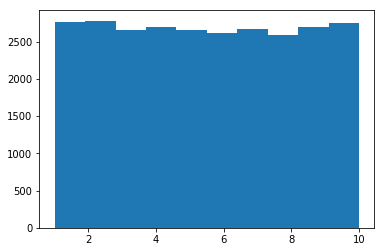

In [66]:
n_exp = 10000
L_select = []
longueur = 150
L = [longueur]*n_exp
L_finales = []
for T in range(100):
    for exp in range(n_exp):
        a = evolution_simple(L[exp])
        L[exp] = a
        if a > 0 and a <= 10:
            L_finales.append(a)
plt.hist(L_finales, bins=10)
plt.show()

Loi de $S_\tau$ et indépendance avec $\tau$ :

In [67]:
n_exp = 100000
L_finales = []
T_final = []
for exp in range(n_exp):
    T = 0
    longueur = 240
    L = [longueur]
    while longueur > 0:
        T += 1
        longueur = evolution_simple(longueur)
        L.append(longueur)
    L_finales.append(L[-1])
    T_final.append(T)

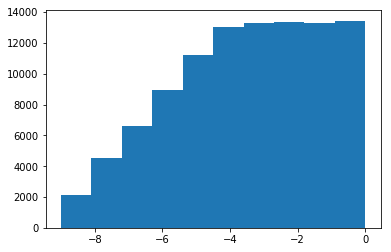

In [68]:
plt.hist(L_finales, bins=10)
plt.show()

In [69]:
np.cov(L_finales, T_final)

array([[  6.04216629,  -1.26178881],
       [ -1.26178881,  71.99095043]])

In [70]:
# Empirical mean
np.mean(T_final)

64.930289999999999

In [72]:
# Theoretical mean
4*240/15 + 104./135

64.77037037037037